# <center> <span style=""><font size="+3"> Principal Component Analysis and Boosting Algorithm Implementation from scratch </font></span> </center> #
<br/>
<center> <span style="color:red; font-size : 18px">Auteur </span> <span style="font-size : 18px"> : Bounhar Abdelaziz </span> </center>

AdaBoost algorithm for a two-class classification problem. The algorithm sequentially applies a weak classification to modified versions of the data. By increasing the weights of the missclassified observations, each weak learner focuses on the error of the previous one. The predictions are aggregated through a weighted majority vote.

In [139]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_hastie_10_2
import matplotlib.pyplot as plt
from tqdm import tqdm

In [140]:
# Useful starting lines
%matplotlib inline

%load_ext autoreload
%autoreload 2

from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Helpers Functions

In [141]:
def plot_error_rate(er_train, er_test):
    
    df_error = pd.DataFrame([er_train, er_test]).T
    df_error.columns = ['Training', 'Test']
    plot1 = df_error.plot(linewidth = 3, figsize = (8,6),
            color = ['lightblue', 'darkblue'], grid = True)
    plot1.set_xlabel('Number of iterations', fontsize = 12)
    plot1.set_xticklabels(range(0,450,50))
    plot1.set_ylabel('Error rate', fontsize = 12)
    plot1.set_title('Error rate vs number of iterations', fontsize = 16)
    plt.axhline(y=er_test[0], linewidth=1, color = 'red', ls = 'dashed')
    plt.savefig('adaboost.pdf',format='pdf')

In [142]:
def get_error_rate(pred, Y):
    return sum(pred != Y) / float(len(Y))

In [143]:
def print_error_rate(err):
    print('Error rate: Training: %.4f - Test: %.4f'.format(err))

## Weak Learners

In [144]:
def generic_clf(Y_train, X_train, Y_test, X_test, clf):
    clf.fit(X_train,Y_train)
    pred_train = clf.predict(X_train)
    pred_test = clf.predict(X_test)
    return get_error_rate(pred_train, Y_train),get_error_rate(pred_test, Y_test)

# Datasets :
##### Generates data for binary classification used in Hastie et al. 2009, Example 10.2.

In [145]:
# Read data
x, y = make_hastie_10_2()
df = pd.DataFrame(x)
df['Y'] = y

# Split into training and test set
train, test = train_test_split(df, test_size = 0.2)
X_train, Y_train = train.iloc[:,:-1], train.iloc[:,-1]
X_test, Y_test = test.iloc[:,:-1], test.iloc[:,-1]

In [146]:
# Fit a simple decision tree first
clf_tree = DecisionTreeClassifier(max_depth = 1, random_state = 1)
er_tree = generic_clf(Y_train, X_train, Y_test, X_test, clf_tree)
print('Single Weak Learner Achieves \n Train Error of {} \n Test Error of {}'.format(er_tree[0],er_tree[1]))

Single Weak Learner Achieves 
 Train Error of 0.45416666666666666 
 Test Error of 0.47541666666666665


# Implement an adaboost classifier

In [147]:
def adaboost_clf(Y_train, X_train, Y_test, X_test, M, clf):
    n_train, n_test = len(X_train), len(X_test)
    # Initialize weights
    w = np.ones(n_train) / n_train # uniform distribution over the weights
    pred_train, pred_test = [np.zeros(n_train), np.zeros(n_test)]
    
    for i in range(M):
        # Fit a classifier with the specific weights
        clf.fit(X_train, Y_train, sample_weight = w)
        pred_train_i = clf.predict(X_train)
        pred_test_i = clf.predict(X_test)
        
        y = Y_train.to_numpy()

        # Indicator function
        miss = np.sum(pred_test_i != Y_test)
        
        
        # Error
        err_m = 0
        for j in range(len(pred_train_i)):
            if pred_train_i[j] != y[j] :
                err_m = err_m + w[j]
        err_m = err_m/np.sum(w)
        
        
        # Equivalent with 1/-1 to update weights
        miss2 = 0
        
        # Alpha
        if np.absolute(np.log((1-err_m)/err_m)) < np.finfo(float).eps :
            alpha_m = np.finfo(float).eps
        else :
            alpha_m = np.log((1-err_m)/err_m)
            
        # New weights
        for j in range(len(w)):
            if pred_train_i[j] != y[j] :                
                w[j] = w[j]*np.exp(alpha_m)
        
        # Add to prediction
        pred_train = [sum(x) for x in zip(pred_train, 
                                          [x * alpha_m for x in pred_train_i])]
        pred_test = [sum(x) for x in zip(pred_test, 
                                         [x * alpha_m for x in pred_test_i])]
    
    pred_train, pred_test = np.sign(pred_train), np.sign(pred_test)
    # Return error rate in train and test set
    #print(w)
    return get_error_rate(pred_train, Y_train), get_error_rate(pred_test, Y_test)

# Fit Adaboost classifier using a decision tree as base estimator

In [148]:
# let's see if the data is scaled
X_train.describe()

,0,1,2,3,4,5,6,7,8,9
count,9600.000000,9600.000000,9600.000000,9600.000000,9600.000000,9600.000000,9600.000000,9600.000000,9600.000000,9600.000000
mean,-0.002764,0.000718,-0.000312,-0.005838,-0.000378,0.015266,0.013182,0.004649,0.010130,0.011597
std,0.998243,0.997048,0.992036,0.997160,1.000038,1.006999,0.996018,0.992166,1.000973,0.993940
min,-3.688008,-3.963332,-3.862628,-3.814698,-3.641475,-3.675005,-4.228269,-3.480437,-3.564527,-3.948343
25%,-0.677368,-0.675066,-0.660567,-0.673960,-0.674201,-0.665933,-0.649516,-0.671814,-0.667513,-0.638948
50%,-0.005041,0.007201,-0.006232,0.006105,-0.010012,0.006476,0.027434,-0.011272,0.010430,0.010758
75%,0.670655,0.678450,0.670771,0.665838,0.667444,0.712064,0.677137,0.659363,0.681641,0.686087
max,3.833251,3.544364,3.652353,3.781675,4.057076,3.581236,4.434690,3.991831,3.609162,3.614570





  0%|                                                                                           | 0/39 [00:00<?, ?it/s]


  3%|██▏                                                                                | 1/39 [00:00<00:17,  2.23it/s]


  5%|████▎                                                                              | 2/39 [00:01<00:22,  1.68it/s]


  8%|██████▍                                                                            | 3/39 [00:02<00:30,  1.18it/s]


 10%|████████▌                                                                          | 4/39 [00:04<00:41,  1.17s/it]


 13%|██████████▋                                                                        | 5/39 [00:07<01:00,  1.77s/it]


 15%|████████████▊                                                                      | 6/39 [00:10<01:07,  2.03s/it]


 18%|██████████████▉                                                                    | 7/39 [00:13<01:15,  2.36s/it]


 21%|████████████████

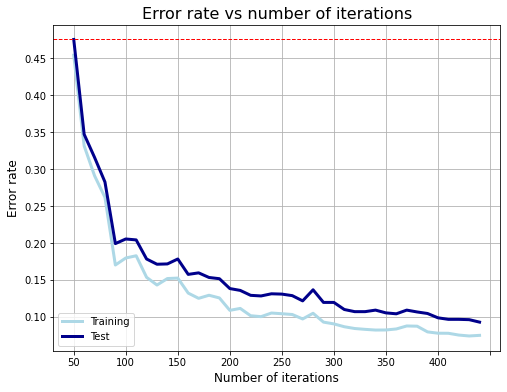

In [149]:
# Test with different number of iterations
er_train, er_test = [er_tree[0]], [er_tree[1]]
x_range = range(10, 400, 10)

for i in tqdm(x_range):
    er_i = adaboost_clf(Y_train, X_train, Y_test, X_test, i, clf_tree)
    er_train.append(er_i[0])
    er_test.append(er_i[1])
    
# Compare error rate vs number of iterations
plot_error_rate(er_train, er_test)

### Comments :

We can clearly see that over the iterations of the training phase, the classifier gets betters and better, untill it reaches a level of error rate =0.1 and stops from improving a lot. Actually, if we increase the number of iterations, after reaching a certain number of iteration, the classifier will be overfitting the training data. 
This treshold is caracterized by : nbrOfIteration >> VCdim(H).

In the next experience, we will try to find this maximum number of Iteration for which we will be overfitting the training data.

In [150]:
# Test with different number of iterations
er_train, er_test = [er_tree[0]], [er_tree[1]]
x_range = range(10, 900, 10)

for i in tqdm(x_range):
    er_i = adaboost_clf(Y_train, X_train, Y_test, X_test, i, clf_tree)
    er_train.append(er_i[0])
    er_test.append(er_i[1])




  0%|                                                                                           | 0/89 [00:00<?, ?it/s]


  1%|▉                                                                                  | 1/89 [00:00<00:37,  2.33it/s]


  2%|█▊                                                                                 | 2/89 [00:01<00:49,  1.76it/s]


  3%|██▊                                                                                | 3/89 [00:02<01:06,  1.30it/s]


  4%|███▋                                                                               | 4/89 [00:04<01:27,  1.03s/it]


  6%|████▋                                                                              | 5/89 [00:06<01:52,  1.34s/it]


  7%|█████▌                                                                             | 6/89 [00:08<02:19,  1.68s/it]


  8%|██████▌                                                                            | 7/89 [00:11<02:48,  2.05s/it]


  9%|███████▍        

In [151]:
def plot_error_rate(er_train, er_test):
    
    df_error = pd.DataFrame([er_train, er_test]).T
    df_error.columns = ['Training', 'Test']
    
    plot1 = df_error.plot( linewidth = 3, 
                           figsize = (12,8),
                           color = ['lightblue', 'darkblue'], 
                           grid = True)
    
    plot1.set_xlabel('Number of iterations', fontsize = 12)
    plot1.set_xticklabels(range(0,900,100))
    
    plot1.set_ylabel('Error rate', fontsize = 12)
    plot1.set_title('Error rate vs number of iterations', fontsize = 16)
    
    plt.axhline(y=er_test[0], linewidth=1, color = 'red', ls = 'dashed')
    
    plt.savefig('adaboost.pdf',format='pdf')

In [152]:
saved_er_train = er_train
saved_er_test = er_test

c:\python36\lib\site-packages\ipykernel_launcher.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  if sys.path[0] == '':


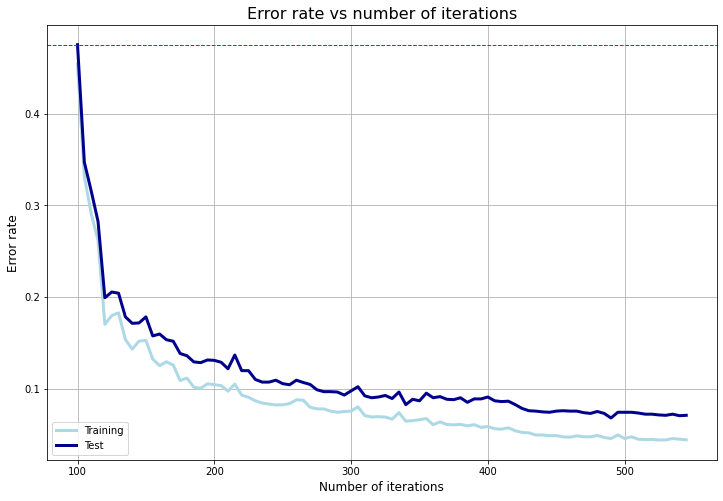

In [153]:
plot_error_rate(saved_er_train, saved_er_test)

### Comments :

We remarked that even with a number of iterations=900, we still don't see this phenomena. We have also tried with higher number of iterations but it's taking too much time and we get some memory failures issues due to computation limits. 

Nevertheless, this was interresting and we can conclude that in this problem, the VCdimension is really huge.

# PCA for dimensionality reduction and image denoising

In [199]:
from keras.datasets import mnist

In [200]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [201]:
x_train.shape

(60000, 28, 28)

In [202]:
len(x_train)

60000

In [203]:
x_train = x_train.reshape(len(x_train), -1)/255
x_test = x_test.reshape(len(x_test), -1)/255

In [204]:
x_train.shape

(60000, 784)

## Question 1. 

Compute the eigendecomposition of the sample covariance matrix and use the eigenvalues to calculate the percentage of variance explained (given by the eigenvalues).
Plot the cumulative sum of these percentages versus the number of components.

In [205]:
all_col_mean = np.mean(x_train,0) # np.mean(x,i) -> i : 0 for columns -- 1 for for rows
x_bar = x_train - all_col_mean

In [206]:
#np.mean(x_bar,0) #The mean of each feature becomes close to zero.

In [207]:
cov_x = np.cov(x_bar.T) # check what would happen if we do the eigendecomp using X.t*X rather than using cov matrix (there should be a scalar diff)

# the scalar is (1/N-1) https://en.wikipedia.org/wiki/Sample_mean_and_covariance

In [208]:
cov_x.shape

(784, 784)

In [209]:
w, P = np.linalg.eigh(cov_x)

In [210]:
#w

In [211]:
d= 169
print(np.sum(w[:d]))
w = -np.sort(-w)
print(np.sum(w[:d]))

0.0014637421981606215
50.4245130074737


In [212]:
#P[:1 , :169].real

In [213]:
print(w.shape)

(784,)


In [214]:
print(P.shape)

(784, 784)


In [215]:
d= 169
w = -np.sort(-w)
w_kept = w[:d]
P_kept = np.diag(w_kept)

In [216]:
#w_kept.real

In [217]:
P_kept = P[:500 , :500]

In [218]:
print(P_kept.shape)

(500, 500)


In [219]:
percentage_eigen_value = [w[i]/np.sum(w) for i in range(len(w)) ]
sum(percentage_eigen_value)

0.9999999999999994

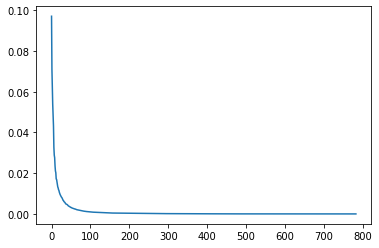

In [220]:
plt.plot(percentage_eigen_value)

In [221]:
my_cumulative_percentage_eigen_value = [np.sum(percentage_eigen_value[:i]) for i in range(len(w))]

In [222]:
cumulative_percentage_eigen_value = np.cumsum(percentage_eigen_value)

In [223]:
#cumulative_percentage_eigen_value

In [224]:
np.allclose(cumulative_percentage_eigen_value, my_cumulative_percentage_eigen_value,  rtol=1e-05)

False

In [225]:
err_precision = 0
for i in range(len(cumulative_percentage_eigen_value)):
    err_i = cumulative_percentage_eigen_value[i] - my_cumulative_percentage_eigen_value[i]
    err_precision = err_precision + err_i
print("err_precision = ",err_precision)

err_precision =  0.9999999999996942


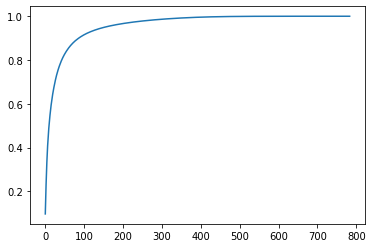

In [226]:
plt.plot(cumulative_percentage_eigen_value)

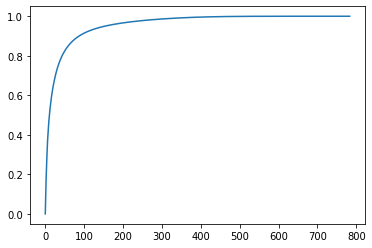

In [227]:
plt.plot(my_cumulative_percentage_eigen_value)

### Comments :

We can clearly see that more than 90% of the data is contained in the first 100 components. Which means that 100 components are sufficient to describe 90% of the data. We also observe that after, there's a certain monotonity, that is the other components doesn't add much informations.
This actually was predictible since in our images the real information (the number) is concentrated in few pixels.

We will build a function down bellow that will give us the exact number of dimensions to keep in order to keep a percentage of the original data.

In [228]:
def findNumberOfDimensionByDesiredCumulativePercentage(cumulative_percentage_eigen_value, desiredCumulativePercentage):
    """ 
    This function helps us find the number of principale components (dimensions) by keeping only the desired percentage
    of informations from the original data.
    """
    
    for i in range(len(cumulative_percentage_eigen_value)):
        if cumulative_percentage_eigen_value[i] >= desiredCumulativePercentage :
            return i

In [229]:
desiredCumulativePercentage = 0.90
findNumberOfDimensionByDesiredCumulativePercentage(cumulative_percentage_eigen_value, desiredCumulativePercentage)

86

* For example to keep 90% of informations of the data we can keep only 86 dimensions, which can be confirmerd from the figure above.

## Question 2
## PCA Algorithm

In [230]:
def PCA(X, forcedNbrDim, desiredCumulativePercentage=0.85, plot=False):
    
    all_col_mean = np.mean(X,0) # np.mean(x,i) -> i : 0 for columns -- 1 for for rows
    # we construct the X bar
    x_bar = X - all_col_mean 
    # covariance matrix
    cov_x = np.cov(x_bar.T)     
    # SVD
    w, P = np.linalg.eig(cov_x)
    
    percentage_eigen_value = [w[i]/np.sum(w) for i in range(len(w)) ]
    print("Sum of percentage_eigen_value : ", sum(percentage_eigen_value))
    cumulative_percentage_eigen_value = np.cumsum(percentage_eigen_value)
    
    if plot :
        plt.plot(cumulative_percentage_eigen_value)
    
    # number of dimensions to keep 
    if forcedNbrDim < 0: # we set a negative forcedDim if we want to use the computation from the cumulative percentage
        d = findNumberOfDimensionByDesiredCumulativePercentage(cumulative_percentage_eigen_value, desiredCumulativePercentage)
    else :
        d = forcedNbrDim
    
    # we keep only the d first eigein values of P
    
    P_kept = P[: , :d]
    print("P_kept : ",P_kept.shape)
    print("Dimensions to keep : ",d)
    #w_kept = w[:d] 
    #P_kept = np.diag(w_kept)
    #Y = np.dot(x_bar, P_kept.real)
    
    Y = np.dot(x_bar, P_kept)
    Xhat = np.dot(Y, P_kept.T) + all_col_mean
    
    # Errors computations
    X_fnom = np.linalg.norm(X, 'fro')
    M = X - Xhat
    M_fnorm = np.linalg.norm(M, 'fro')
    reconstructionError = M_fnorm/X_fnom
    print("Normalized reconstruction error : ",reconstructionError)
    return Xhat, Y, d, reconstructionError

In [231]:
desiredCumulativePercentage=0.85
forcedNbrDim = -1
Xhat, Y, d, reconstructionError = PCA(x_train, forcedNbrDim, desiredCumulativePercentage)

Sum of percentage_eigen_value :  (0.9999999999999998+0j)
P_kept :  (784, 58)
Dimensions to keep :  58
Normalized reconstruction error :  0.3024527547774581


In [232]:
print(x_train.shape)
print(Xhat.shape)
print(Y.shape)

(60000, 784)
(60000, 784)
(60000, 58)


In [233]:
Xhat[0].reshape(28,-1).shape

(28, 28)

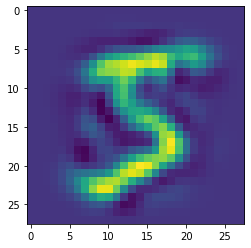

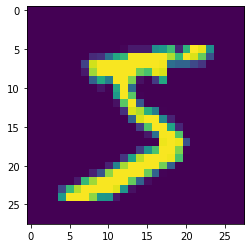

In [234]:
i = 0
y = Xhat[i].real.reshape(28,28)
plt.imshow(y)
plt.show()
y = x_train[i].real.reshape(28,28)
plt.imshow(y)

----------- p =  50 -------------
Sum of percentage_eigen_value :  (0.9999999999999998+0j)
P_kept :  (784, 50)
Dimensions to keep :  50
Normalized reconstruction error :  0.3244839105237107


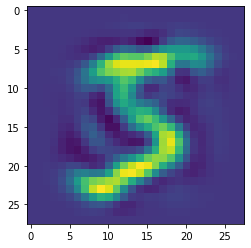

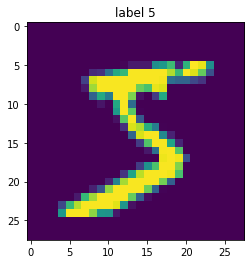



----------- p =  250 -------------
Sum of percentage_eigen_value :  (0.9999999999999998+0j)
P_kept :  (784, 250)
Dimensions to keep :  250
Normalized reconstruction error :  0.11476437541142882


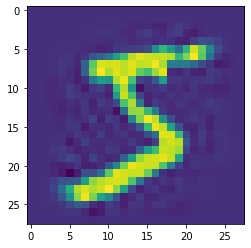

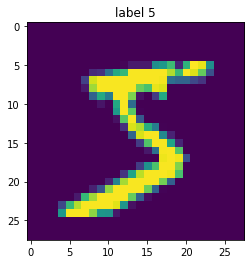



----------- p =  500 -------------
Sum of percentage_eigen_value :  (0.9999999999999998+0j)
P_kept :  (784, 500)
Dimensions to keep :  500
Normalized reconstruction error :  0.02121724407664908


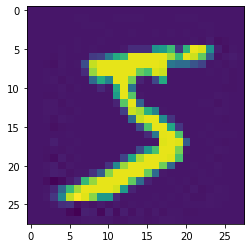

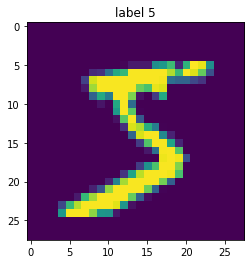



[0.3244839105237107, 0.11476437541142882, 0.02121724407664908]


In [235]:
dimensions = [50, 250, 500]
reconstructionErrors = []
for p in dimensions :
    print("----------- p = ",p,"-------------")
    Xhat, Y, d, reconstructionError = PCA(x_train, p, desiredCumulativePercentage)
    reconstructionErrors.append(reconstructionError)
    
    i = 0
    xhat_im = Xhat[i].real.reshape(28,28)
    plt.imshow(xhat_im)
    plt.show()
    x_im = x_train[i].real.reshape(28,28)
    plt.imshow(x_im)
    plt.title('label %d'%(y_train[i]))
    plt.show()
    print("\n")
    
print(reconstructionErrors)

## Playing with the images


## Question 3
### Adding Noise to image data

In [236]:
def generateNoise(data, sigma2, mean=0):
    
    #cov_matrix = sigma2*np.diag([1,1])
    #bruit = sigma2*np.random.multivariate_normal(mean, cov_matrix, data.shape[0])
    
    bruit = np.random.normal(mean, sigma2, data.shape)       #(data.shape[0], data.shape[1])      
    
    # we add the noise
    data_bruite = data + bruit
    
    # Rescalling the pixels new values to [0,255]  to avoid having pixels with values greater than 255 or less than 0.
    #data_bruite[ data_bruite > 255 ] = 255 
    #data_bruite[ data_bruite < 0 ] = 0
    data_bruite = np.clip(data_bruite, 0, 1)
    #reshaping the data
    data_bruite[0].reshape(28,28).shape
    
    return data_bruite
    
def plotImageData(nbrImageToPlot, data, label):
    
    for k in range(nbrImageToPlot):
        plt.imshow(data[k].reshape(28,28))
        plt.title('label %d'%(label[k]))
        plt.show()

def addNoiseToData(data, label, sigma2, nbrImageToPlot, mean=0) :
    
    data_bruite = generateNoise(data, sigma2, mean)
    plotImageData(nbrImageToPlot, data_bruite, label)
    
    return data_bruite

In [237]:
x_train[0].reshape(28,28).shape

(28, 28)

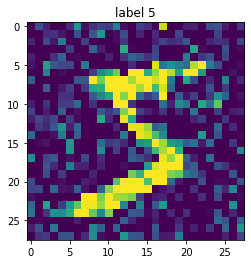

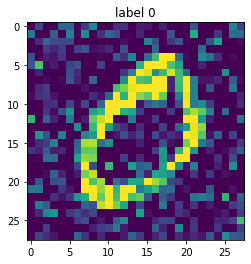

min :  0.0
max :  1.0


In [238]:
sigma2 = 0.25
mean = 0
nbrImageToPlot = 2
data_bruite = addNoiseToData(x_train, y_train, sigma2, nbrImageToPlot, mean)
print("min : ",np.min(data_bruite))
print("max : ",np.max(data_bruite))

Sum of percentage_eigen_value :  1.0000000000000002
P_kept :  (784, 534)
Dimensions to keep :  534
Normalized reconstruction error :  0.2311192696947146


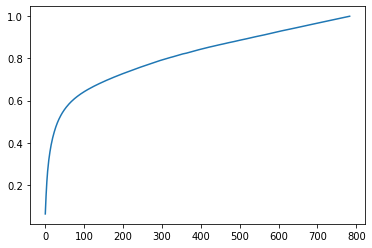

In [239]:
desiredCumulativePercentage=0.9
forcedNbrDim = -1
Xhat, Y, d, reconstructionError = PCA(data_bruite, forcedNbrDim, desiredCumulativePercentage, plot=True)

### Comments : 

In the case where we added the noise, we don't have the same curve for the cumulative explained variance versus the number of components. In fact, this is due to the fact that when there's a noise in the data, each components adds informations and thus is no more useless.

We need 534 component to describe 90% of the data, which is almost 5 times higher than the first case without noise.

To put in contrast with we had seen in the first, here the real information is hidded by the noise rather then being clear and  concentrated in few pixels.

In [240]:
desiredCumulativePercentage=0.9
forcedNbrDim = -1

Xhat_test, Y, d, reconstructionError = PCA(data_bruite, forcedNbrDim, desiredCumulativePercentage)

Sum of percentage_eigen_value :  1.0000000000000002
P_kept :  (784, 534)
Dimensions to keep :  534
Normalized reconstruction error :  0.2311192696947146


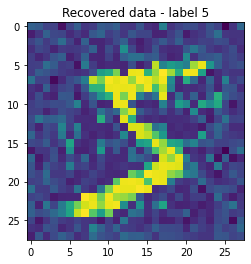

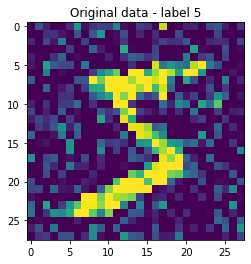

In [241]:
i = 0

xhat_im = Xhat_test[i].real.reshape(28,28)
plt.imshow(xhat_im)
plt.title('Recovered data - label %d'%(y_train[i]))
plt.show()

x_im = data_bruite[i].real.reshape(28,28)
plt.imshow(x_im)
plt.title('Original data - label %d'%(y_train[i]))
plt.show()

## Question 4

----------- sigma2 =  0.15 -------------
Sum of percentage_eigen_value :  1.0000000000000004
P_kept :  (784, 250)
Dimensions to keep :  250
Normalized reconstruction error :  0.2456716415799223


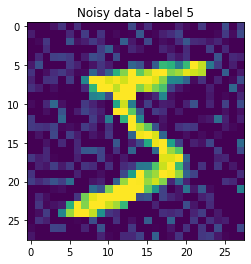

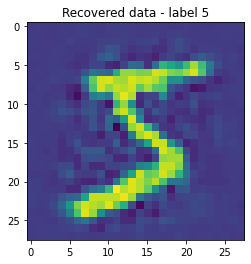



----------- sigma2 =  0.25 -------------
Sum of percentage_eigen_value :  0.9999999999999986
P_kept :  (784, 250)
Dimensions to keep :  250
Normalized reconstruction error :  0.35659711316604


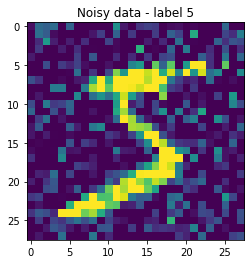

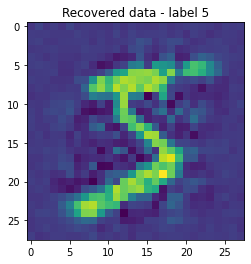



----------- sigma2 =  0.5 -------------
Sum of percentage_eigen_value :  0.9999999999999998
P_kept :  (784, 250)
Dimensions to keep :  250
Normalized reconstruction error :  0.5291718023757181


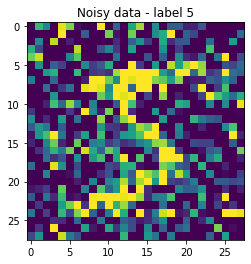

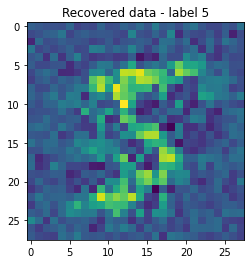



[0.2456716415799223, 0.35659711316604, 0.5291718023757181]
[250, 250, 250]


In [242]:
sigmas2 = [0.15, 0.25, 0.50]
mean = 0
reconstructionErrors = []
dimensionsToKeep = []

for sigma2 in sigmas2 :
    print("----------- sigma2 = ",sigma2,"-------------")
    data_bruite = addNoiseToData(x_train, y_train, sigma2, 0, mean)
    
    forcedNbrDim = 250
    desiredCumulativePercentage= 0.85 # not really usefull here, we already fixed forcedNbrDim to 250, use just for the PCA function params definition
    
    Xhat, Y, d, reconstructionError = PCA(data_bruite, forcedNbrDim, desiredCumulativePercentage)
    reconstructionErrors.append(reconstructionError)
    dimensionsToKeep.append(d)
    
    i = 0
   
    x_im = data_bruite[i].real.reshape(28,28)
    plt.imshow(x_im)
    plt.title('Noisy data - label %d'%(y_train[i]))
    plt.show()
    
    xhat_im = Xhat[i].real.reshape(28,28)
    plt.imshow(xhat_im)
    plt.title('Recovered data - label %d'%(y_train[i]))
    plt.show()
    
    print("\n")
    
print(reconstructionErrors)
print(dimensionsToKeep)

Text(0, 0.5, 'Reconstruction error')

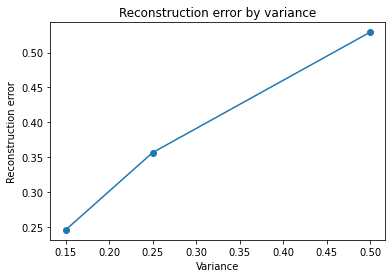

In [243]:
plt.plot(sigmas2, reconstructionErrors, '-o')
plt.title("Reconstruction error by variance")
plt.xlabel('Variance')
plt.ylabel('Reconstruction error')

### Comments : 

By fixing the number of components to keep to 250 and varying the variance, we see that the reconstruction error grows with the variance growing as shown in the Figure above.
Actually what happens is that, we are not only removing the noise component, but also part of the energy related to the input data, therefore the reconstruction error grows.